# GAN and cGAN for Tabular Data Generation

## Assignment 4: Deep Learning

This notebook implements:
1. **GAN** - Standard GAN for synthetic tabular data generation
2. **cGAN** - Conditional GAN with label conditioning

## Key Design Decisions
- **WGAN-GP**: Wasserstein loss with gradient penalty for stable training
- **Mixture Model**: Explicit handling of zero-inflated features (capital-gain, capital-loss) and peak values (hours-per-week=40)
- **Gumbel-Softmax**: Differentiable categorical sampling
- **Label Conditioning**: cGAN concatenates one-hot label to both generator input and discriminator input

## 1. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
import os

warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Using device: cpu


## 2. Load and Explore Data

In [2]:
data, meta = arff.loadarff('../data/adult.arff')
df = pd.DataFrame(data)

# Decode bytes to strings
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.decode('utf-8')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['income'].value_counts(normalize=True))

Dataset shape: (32561, 15)

Target distribution:
income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64


## 3. Feature Configuration

In [3]:
# Feature categorization
ZERO_INFLATED = ['capital-gain', 'capital-loss']  # ~90%+ zeros
PEAK_INFLATED = ['hours-per-week']  # 47% at value 40
PEAK_VALUES = {'hours-per-week': 40}

# Log-transform for right-skewed features
LOG_TRANSFORM = ['fnlwgt']

CONTINUOUS = ['age', 'fnlwgt']  # fnlwgt gets log transform

# Treat education-num as categorical (16 discrete values)
DISCRETE_AS_CATEGORICAL = ['education-num']

CATEGORICAL = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country']

TARGET = 'income'
N_CLASSES = 2  # <=50K, >50K

print("Feature Configuration:")
print(f"  Zero-inflated: {ZERO_INFLATED}")
print(f"  Peak-inflated: {PEAK_INFLATED}")
print(f"  Log-transform: {LOG_TRANSFORM}")
print(f"  Continuous: {CONTINUOUS}")
print(f"  Discrete as categorical: {DISCRETE_AS_CATEGORICAL}")
print(f"  Categorical: {CATEGORICAL}")

Feature Configuration:
  Zero-inflated: ['capital-gain', 'capital-loss']
  Peak-inflated: ['hours-per-week']
  Log-transform: ['fnlwgt']
  Continuous: ['age', 'fnlwgt']
  Discrete as categorical: ['education-num']
  Categorical: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## 4. Preprocessor

In [4]:
class Preprocessor:
    """Preprocess tabular data for GAN training."""
    
    def __init__(self):
        self.scalers = {}
        self.zero_props = {}
        self.peak_props = {}
        self.cat_mappings = {}
        self.cat_dims = {}
        self.label_encoder = LabelEncoder()
        self.mode_values = {}
        self.feature_info = []  # (name, type, dim)
        self.log_transform = LOG_TRANSFORM
        
    def fit(self, df):
        df = df.copy()
        
        # Handle missing values in categorical
        for col in CATEGORICAL:
            valid = df[df[col] != '?'][col]
            if len(valid) > 0:
                self.mode_values[col] = valid.mode()[0]
                df[col] = df[col].replace('?', self.mode_values[col])
        
        # Zero-inflated features
        for col in ZERO_INFLATED:
            self.zero_props[col] = (df[col] == 0).mean()
            non_zero = df[df[col] > 0][col].values
            scaler = MinMaxScaler()
            scaler.fit(non_zero.reshape(-1, 1))
            self.scalers[col] = scaler
            self.feature_info.append((col, 'zero_inflated', 2))
        
        # Peak-inflated features
        for col in PEAK_INFLATED:
            peak_val = PEAK_VALUES[col]
            self.peak_props[col] = (df[col] == peak_val).mean()
            non_peak = df[df[col] != peak_val][col].values
            scaler = MinMaxScaler()
            scaler.fit(non_peak.reshape(-1, 1))
            self.scalers[col] = scaler
            self.feature_info.append((col, 'peak_inflated', 2))
        
        # Continuous features (with optional log transform)
        for col in CONTINUOUS:
            values = df[col].values.copy().astype(np.float64)
            if col in self.log_transform:
                values = np.log1p(values)
            scaler = MinMaxScaler()
            scaler.fit(values.reshape(-1, 1))
            self.scalers[col] = scaler
            self.feature_info.append((col, 'continuous', 1))
        
        # Discrete features treated as categorical
        for col in DISCRETE_AS_CATEGORICAL:
            unique_vals = sorted(df[col].unique())
            self.cat_mappings[col] = {v: i for i, v in enumerate(unique_vals)}
            self.cat_dims[col] = len(unique_vals)
            self.feature_info.append((col, 'categorical', len(unique_vals)))
        
        # Categorical features
        for col in CATEGORICAL:
            unique_vals = sorted(df[col].unique())
            self.cat_mappings[col] = {v: i for i, v in enumerate(unique_vals)}
            self.cat_dims[col] = len(unique_vals)
            self.feature_info.append((col, 'categorical', len(unique_vals)))
        
        self.label_encoder.fit(df[TARGET])
        return self
    
    def transform(self, df):
        df = df.copy()
        
        for col, mode in self.mode_values.items():
            df[col] = df[col].replace('?', mode)
        
        arrays = []
        
        # Zero-inflated
        for col in ZERO_INFLATED:
            is_zero = (df[col] == 0).astype(np.float32).values.reshape(-1, 1)
            values = df[col].values.copy().astype(np.float32)
            mask = values > 0
            if mask.any():
                values[mask] = self.scalers[col].transform(values[mask].reshape(-1, 1)).flatten()
            values[~mask] = 0  # When zero, value column = 0
            arrays.extend([is_zero, values.reshape(-1, 1)])
        
        # Peak-inflated
        for col in PEAK_INFLATED:
            peak_val = PEAK_VALUES[col]
            is_peak = (df[col] == peak_val).astype(np.float32).values.reshape(-1, 1)
            values = df[col].values.copy().astype(np.float32)
            mask = values != peak_val
            if mask.any():
                values[mask] = self.scalers[col].transform(values[mask].reshape(-1, 1)).flatten()
            values[~mask] = 0.5  # When peak, value column = 0.5
            arrays.extend([is_peak, values.reshape(-1, 1)])
        
        # Continuous (with optional log transform)
        for col in CONTINUOUS:
            values = df[col].values.copy().astype(np.float64)
            if col in self.log_transform:
                values = np.log1p(values)
            scaled = self.scalers[col].transform(values.reshape(-1, 1))
            arrays.append(scaled.astype(np.float32))
        
        # Discrete as categorical + Categorical
        for col in DISCRETE_AS_CATEGORICAL + CATEGORICAL:
            n_cat = self.cat_dims[col]
            onehot = np.zeros((len(df), n_cat), dtype=np.float32)
            for i, val in enumerate(df[col]):
                if val in self.cat_mappings[col]:
                    onehot[i, self.cat_mappings[col][val]] = 1
            arrays.append(onehot)
        
        X = np.hstack(arrays)
        y = self.label_encoder.transform(df[TARGET])
        return X, y
    
    def get_dim(self):
        return sum(d for _, _, d in self.feature_info)
    
    def get_continuous_indices(self):
        """Get indices of continuous feature values for distribution losses."""
        indices = []
        pos = 0
        for name, ftype, dim in self.feature_info:
            if ftype == 'zero_inflated':
                indices.append((name, 'zero_inflated', pos + 1))
                pos += 2
            elif ftype == 'peak_inflated':
                indices.append((name, 'peak_inflated', pos + 1))
                pos += 2
            elif ftype == 'continuous':
                indices.append((name, 'continuous', pos))
                pos += 1
            else:
                pos += dim
        return indices
    
    def print_info(self):
        print(f"\nData dimensions: {self.get_dim()}")
        pos = 0
        for name, ftype, dim in self.feature_info:
            extra = ""
            if name in self.log_transform:
                extra = " [LOG]"
            print(f"  [{pos:3d}-{pos+dim-1:3d}] {name} ({ftype}){extra}")
            pos += dim

## 5. Data Preparation

In [5]:
def prepare_data(df, seed=42):
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=seed, stratify=df[TARGET]
    )
    
    prep = Preprocessor()
    prep.fit(train_df)
    
    X_train, y_train = prep.transform(train_df)
    X_test, y_test = prep.transform(test_df)
    
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Label distribution - Train: {np.bincount(y_train)/len(y_train)}")
    
    return X_train, X_test, y_train, y_test, prep

## 6. GAN Architecture

In [6]:
class Generator(nn.Module):
    """Generator with skip connections and learned variance."""
    
    def __init__(self, latent_dim, output_dim, prep, hidden_dim=256, cond_dim=0):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.prep = prep
        self.cond_dim = cond_dim
        
        input_dim = latent_dim + cond_dim
        
        # Main backbone with skip connections
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.ln2 = nn.LayerNorm(hidden_dim * 2)
        
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.ln3 = nn.LayerNorm(hidden_dim * 2)
        
        # Skip connection projection
        self.skip_proj = nn.Linear(hidden_dim, hidden_dim * 2)
        
        # Count continuous features for variance parameters
        n_cont = sum(1 for _, ftype, _ in prep.feature_info 
                     if ftype in ['zero_inflated', 'peak_inflated', 'continuous'])
        
        # Output head (extra outputs for variance)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim + n_cont)
        
        # Learnable per-feature scaling
        self.cont_bias = nn.Parameter(torch.zeros(n_cont))
        self.cont_scale = nn.Parameter(torch.ones(n_cont))
        
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, z, labels=None, temp=0.5, hard=False):
        if self.cond_dim > 0 and labels is not None:
            labels_onehot = F.one_hot(labels, self.cond_dim).float()
            z = torch.cat([z, labels_onehot], dim=1)
        
        # Backbone with skip connection
        h1 = self.activation(self.ln1(self.fc1(z)))
        h2 = self.activation(self.ln2(self.fc2(h1)))
        h3 = self.activation(self.ln3(self.fc3(h2)))
        h3 = h3 + self.skip_proj(h1)  # Skip connection
        
        x = self.fc_out(h3)
        
        return self._apply_activations(x, temp, hard)
    
    def _apply_activations(self, x, temp, hard):
        outputs = []
        pos = 0
        extra_pos = self.output_dim  # Variance params start here
        cont_idx = 0
        
        for name, ftype, dim in self.prep.feature_info:
            if ftype == 'zero_inflated':
                is_zero_logit = x[:, pos]
                value_logit = x[:, pos + 1]
                log_var = x[:, extra_pos]
                extra_pos += 1
                
                is_zero_prob = torch.sigmoid(is_zero_logit)
                
                # Base value with learned noise
                base_val = torch.sigmoid(value_logit)
                if self.training:
                    noise = torch.randn_like(base_val) * torch.exp(0.5 * log_var) * 0.1
                    value = torch.clamp(base_val + noise, 0, 1)
                else:
                    value = base_val
                
                # Apply learned scale/bias
                value = value * self.cont_scale[cont_idx] + self.cont_bias[cont_idx]
                value = torch.clamp(value, 0, 1)
                cont_idx += 1
                
                if hard or not self.training:
                    is_zero = (torch.rand_like(is_zero_prob) < is_zero_prob).float()
                    # When is_zero=1, final_value=0 (matching encoding)
                    final_value = (1 - is_zero) * value
                    outputs.extend([is_zero.unsqueeze(1), final_value.unsqueeze(1)])
                else:
                    outputs.extend([is_zero_prob.unsqueeze(1), value.unsqueeze(1)])
                
                pos += 2
                
            elif ftype == 'peak_inflated':
                is_peak_logit = x[:, pos]
                value_logit = x[:, pos + 1]
                log_var = x[:, extra_pos]
                extra_pos += 1
                
                is_peak_prob = torch.sigmoid(is_peak_logit)
                
                # Base value with learned noise (wider for hours-per-week)
                base_val = torch.sigmoid(value_logit)
                if self.training:
                    noise = torch.randn_like(base_val) * torch.exp(0.5 * log_var) * 0.15
                    value = torch.clamp(base_val + noise, 0, 1)
                else:
                    noise = torch.randn_like(base_val) * 0.1
                    value = torch.clamp(base_val + noise, 0, 1)
                
                # Apply learned scale/bias
                value = value * self.cont_scale[cont_idx] + self.cont_bias[cont_idx]
                value = torch.clamp(value, 0, 1)
                cont_idx += 1
                
                if hard or not self.training:
                    is_peak = (torch.rand_like(is_peak_prob) < is_peak_prob).float()
                    # When is_peak=1, value=0.5 (matching encoding)
                    final_value = is_peak * 0.5 + (1 - is_peak) * value
                    outputs.extend([is_peak.unsqueeze(1), final_value.unsqueeze(1)])
                else:
                    outputs.extend([is_peak_prob.unsqueeze(1), value.unsqueeze(1)])
                
                pos += 2
                
            elif ftype == 'continuous':
                value_logit = x[:, pos]
                log_var = x[:, extra_pos]
                extra_pos += 1
                
                base_val = torch.sigmoid(value_logit)
                if self.training:
                    noise = torch.randn_like(base_val) * torch.exp(0.5 * log_var) * 0.1
                    value = torch.clamp(base_val + noise, 0, 1)
                else:
                    noise = torch.randn_like(base_val) * 0.05
                    value = torch.clamp(base_val + noise, 0, 1)
                
                # Apply learned scale/bias
                value = value * self.cont_scale[cont_idx] + self.cont_bias[cont_idx]
                value = torch.clamp(value, 0, 1)
                cont_idx += 1
                
                outputs.append(value.unsqueeze(1))
                pos += 1
                
            elif ftype == 'categorical':
                logits = x[:, pos:pos + dim]
                if hard or not self.training:
                    idx = logits.argmax(dim=-1, keepdim=True)
                    onehot = torch.zeros_like(logits).scatter_(-1, idx, 1.0)
                else:
                    # Gumbel-softmax
                    gumbels = -torch.log(-torch.log(torch.rand_like(logits) + 1e-20) + 1e-20)
                    y = F.softmax((logits + gumbels) / temp, dim=-1)
                    idx = y.argmax(dim=-1, keepdim=True)
                    onehot = torch.zeros_like(logits).scatter_(-1, idx, 1.0)
                    onehot = onehot - y.detach() + y  # straight-through
                outputs.append(onehot)
                pos += dim
        
        return torch.cat(outputs, dim=1)


class Discriminator(nn.Module):
    """Discriminator with spectral normalization."""
    
    def __init__(self, input_dim, hidden_dim=256, cond_dim=0, dropout=0.3):
        super().__init__()
        self.cond_dim = cond_dim
        
        total_input = input_dim + cond_dim
        
        self.fc1 = nn.utils.spectral_norm(nn.Linear(total_input, hidden_dim))
        self.fc2 = nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim))
        self.fc3 = nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim // 2))
        self.fc_out = nn.Linear(hidden_dim // 2, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, x, labels=None):
        if self.cond_dim > 0 and labels is not None:
            labels_onehot = F.one_hot(labels, self.cond_dim).float()
            x = torch.cat([x, labels_onehot], dim=1)
        
        h = self.activation(self.fc1(x))
        h = self.dropout(h)
        h = self.activation(self.fc2(h))
        h = self.dropout(h)
        h = self.activation(self.fc3(h))
        h = self.dropout(h)
        return self.fc_out(h)

## 7. Loss Functions

In [7]:
def gradient_penalty(D, real, fake, labels, device):
    """WGAN-GP gradient penalty."""
    batch_size = real.size(0)
    alpha = torch.rand(batch_size, 1, device=device).expand_as(real)
    interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    
    d_out = D(interp, labels)
    
    grads = torch.autograd.grad(
        outputs=d_out, inputs=interp,
        grad_outputs=torch.ones_like(d_out),
        create_graph=True, retain_graph=True
    )[0]
    
    return ((grads.view(batch_size, -1).norm(2, dim=1) - 1) ** 2).mean()


def proportion_loss(fake, prep):
    """Match proportions of zeros/peaks."""
    loss = 0.0
    pos = 0
    
    for name, ftype, dim in prep.feature_info:
        if ftype == 'zero_inflated':
            pred_prop = fake[:, pos].mean()
            target = prep.zero_props[name]
            loss += (pred_prop - target) ** 2
            pos += 2
        elif ftype == 'peak_inflated':
            pred_prop = fake[:, pos].mean()
            target = prep.peak_props[name]
            loss += (pred_prop - target) ** 2
            pos += 2
        elif ftype == 'continuous':
            pos += 1
        elif ftype == 'categorical':
            pos += dim
    
    return loss


def quantile_loss(real, fake, prep, n_quantiles=20):
    """Match quantiles of continuous features."""
    loss = 0.0
    cont_indices = prep.get_continuous_indices()
    quantiles = torch.linspace(0.05, 0.95, n_quantiles)
    
    for name, ftype, idx in cont_indices:
        real_col = real[:, idx]
        fake_col = fake[:, idx]
        
        for q in quantiles:
            real_q = torch.quantile(real_col, q.item())
            fake_q = torch.quantile(fake_col, q.item())
            loss += (real_q - fake_q) ** 2
    
    return loss / (len(cont_indices) * n_quantiles)


def moment_loss(real, fake, prep):
    """Match mean, std, and skewness of continuous features."""
    loss = 0.0
    cont_indices = prep.get_continuous_indices()
    
    for name, ftype, idx in cont_indices:
        real_col = real[:, idx]
        fake_col = fake[:, idx]
        
        # Mean
        loss += (real_col.mean() - fake_col.mean()) ** 2
        
        # Std
        loss += (real_col.std() - fake_col.std()) ** 2
        
        # Skewness
        real_centered = real_col - real_col.mean()
        fake_centered = fake_col - fake_col.mean()
        real_skew = (real_centered ** 3).mean() / (real_col.std() ** 3 + 1e-8)
        fake_skew = (fake_centered ** 3).mean() / (fake_col.std() ** 3 + 1e-8)
        loss += 0.5 * (real_skew - fake_skew) ** 2
    
    return loss / len(cont_indices)


def correlation_loss(real, fake, prep):
    """Preserve correlations between continuous features."""
    cont_indices = prep.get_continuous_indices()
    indices = [idx for _, _, idx in cont_indices]
    
    if len(indices) < 2:
        return torch.tensor(0.0, device=real.device)
    
    real_cont = real[:, indices]
    fake_cont = fake[:, indices]
    
    def corrcoef(x):
        x = x - x.mean(dim=0, keepdim=True)
        x = x / (x.std(dim=0, keepdim=True) + 1e-8)
        return torch.mm(x.T, x) / (x.shape[0] - 1)
    
    real_corr = corrcoef(real_cont)
    fake_corr = corrcoef(fake_cont)
    
    return F.mse_loss(fake_corr, real_corr)


def categorical_loss(real, fake, prep):
    """Match categorical frequency distributions."""
    loss = 0.0
    pos = 0
    n_cat = 0
    
    for name, ftype, dim in prep.feature_info:
        if ftype == 'categorical':
            fake_freq = fake[:, pos:pos + dim].mean(dim=0)
            real_freq = real[:, pos:pos + dim].mean(dim=0)
            loss += F.mse_loss(fake_freq, real_freq)
            n_cat += 1
            pos += dim
        elif ftype in ['zero_inflated', 'peak_inflated']:
            pos += 2
        elif ftype == 'continuous':
            pos += 1
    
    return loss / max(n_cat, 1)

## 8. Training Function

In [8]:
def train_gan(X_train, y_train, prep, 
              latent_dim=128, hidden_dim=256,
              batch_size=256, epochs=300,
              lr_g=2e-4, lr_d=1e-4, n_critic=5,
              lambda_gp=10, lambda_prop=1.0,
              lambda_quant=0.5, lambda_moment=0.5,
              lambda_corr=1.0, lambda_cat=0.2,
              conditional=False, seed=42):
    """
    Train GAN or cGAN with multiple distribution matching losses.
    """
    set_seed(seed)
    
    data_dim = prep.get_dim()
    cond_dim = N_CLASSES if conditional else 0
    
    G = Generator(latent_dim, data_dim, prep, hidden_dim, cond_dim).to(device)
    D = Discriminator(data_dim, hidden_dim, cond_dim).to(device)
    
    opt_g = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.9))
    opt_d = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.9))
    
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.LongTensor(y_train)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    history = {'g_loss': [], 'd_loss': [], 'prop': [], 'quant': [], 
               'moment': [], 'corr': []}
    
    for epoch in tqdm(range(epochs), desc="Training"):
        g_losses, d_losses = [], []
        prop_losses, quant_losses, mom_losses, corr_losses = [], [], [], []
        
        for real_x, real_y in loader:
            bs = real_x.size(0)
            real_x = real_x.to(device)
            real_y = real_y.to(device) if conditional else None
            
            # Train Discriminator
            for _ in range(n_critic):
                opt_d.zero_grad()
                
                z = torch.randn(bs, latent_dim, device=device)
                fake_y = real_y if conditional else None
                fake_x = G(z, fake_y, hard=False)
                
                # Trim to data_dim (exclude variance params)
                fake_x_trim = fake_x[:, :data_dim]
                
                d_real = D(real_x, real_y)
                d_fake = D(fake_x_trim.detach(), fake_y)
                
                gp = gradient_penalty(D, real_x, fake_x_trim.detach(), real_y, device)
                d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gp
                
                d_loss.backward()
                opt_d.step()
            
            # Train Generator
            opt_g.zero_grad()
            
            z = torch.randn(bs, latent_dim, device=device)
            fake_x = G(z, fake_y, hard=False)
            fake_x_trim = fake_x[:, :data_dim]
            
            # WGAN loss
            g_loss_wgan = -D(fake_x_trim, fake_y).mean()
            
            # Auxiliary losses
            p_loss = proportion_loss(fake_x_trim, prep)
            q_loss = quantile_loss(real_x, fake_x_trim, prep)
            m_loss = moment_loss(real_x, fake_x_trim, prep)
            c_loss = correlation_loss(real_x, fake_x_trim, prep)
            cat_loss = categorical_loss(real_x, fake_x_trim, prep)
            
            # Total loss
            g_loss = (g_loss_wgan + 
                     lambda_prop * p_loss + 
                     lambda_quant * q_loss +
                     lambda_moment * m_loss +
                     lambda_corr * c_loss +
                     lambda_cat * cat_loss)
            
            g_loss.backward()
            opt_g.step()
            
            g_losses.append(g_loss_wgan.item())
            d_losses.append(d_loss.item())
            prop_losses.append(p_loss.item())
            quant_losses.append(q_loss.item())
            mom_losses.append(m_loss.item())
            corr_losses.append(c_loss.item())
        
        history['g_loss'].append(np.mean(g_losses))
        history['d_loss'].append(np.mean(d_losses))
        history['prop'].append(np.mean(prop_losses))
        history['quant'].append(np.mean(quant_losses))
        history['moment'].append(np.mean(mom_losses))
        history['corr'].append(np.mean(corr_losses))
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: D={history['d_loss'][-1]:.4f}, "
                  f"G={history['g_loss'][-1]:.4f}, Q={history['quant'][-1]:.4f}")
    
    return G, D, history

## 9. Generation

In [9]:
def generate(G, n_samples, prep, labels=None):
    """Generate synthetic samples."""
    G.eval()
    dev = next(G.parameters()).device
    data_dim = prep.get_dim()
    
    with torch.no_grad():
        z = torch.randn(n_samples, G.latent_dim, device=dev)
        if labels is not None:
            labels = torch.LongTensor(labels).to(dev)
        fake = G(z, labels, hard=True)
        # Trim to data_dim (exclude variance params)
        fake = fake[:, :data_dim]
    
    return fake.cpu().numpy()


def generate_with_label_ratio(G, n_samples, prep, label_ratio):
    """Generate cGAN samples with specific label ratio."""
    n_class0 = int(n_samples * label_ratio[0])
    n_class1 = n_samples - n_class0
    
    labels = np.concatenate([np.zeros(n_class0), np.ones(n_class1)]).astype(int)
    np.random.shuffle(labels)
    
    X_fake = generate(G, n_samples, prep, labels)
    return X_fake, labels

## 10. Evaluation Metrics

In [10]:
def detection_metric(X_real, X_fake, n_folds=4, seed=42):
    """Detection AUC: can RF distinguish real from synthetic?"""
    y_real = np.zeros(len(X_real))
    y_fake = np.ones(len(X_fake))
    
    X = np.vstack([X_real, X_fake])
    y = np.concatenate([y_real, y_fake])
    
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    aucs = []
    
    for train_idx, test_idx in kf.split(X, y):
        rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
        rf.fit(X[train_idx], y[train_idx])
        proba = rf.predict_proba(X[test_idx])[:, 1]
        aucs.append(roc_auc_score(y[test_idx], proba))
    
    return np.mean(aucs), np.std(aucs)


def efficacy_metric(X_train, y_train, X_fake, y_fake, X_test, y_test, seed=42):
    """Efficacy: is synthetic data useful for training?"""
    # Train on real
    rf_real = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_real.fit(X_train, y_train)
    auc_real = roc_auc_score(y_test, rf_real.predict_proba(X_test)[:, 1])
    
    # Train on synthetic
    rf_fake = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_fake.fit(X_fake, y_fake)
    auc_fake = roc_auc_score(y_test, rf_fake.predict_proba(X_test)[:, 1])
    
    return auc_fake / auc_real, auc_real, auc_fake

## 11. Visualization

In [14]:
def plot_losses(history, title, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    axes[0, 0].plot(history['g_loss'], label='Generator')
    axes[0, 0].plot(history['d_loss'], label='Discriminator')
    axes[0, 0].set_title('GAN Losses')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history['prop'], color='green')
    axes[0, 1].set_title('Proportion Loss')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[0, 2].plot(history['quant'], color='purple')
    axes[0, 2].set_title('Quantile Loss')
    axes[0, 2].grid(True, alpha=0.3)
    
    axes[1, 0].plot(history['moment'], color='orange')
    axes[1, 0].set_title('Moment Loss')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(history['corr'], color='red')
    axes[1, 1].set_title('Correlation Loss')
    axes[1, 1].grid(True, alpha=0.3)
    
    axes[1, 2].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_distributions(X_real, X_fake, prep, title, save_path=None):
    """Compare feature distributions."""
    # Get continuous feature indices
    cont_features = prep.get_continuous_indices()
    
    n = len(cont_features)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, (name, ftype, idx) in enumerate(cont_features[:6]):
        ax = axes[i]
        ax.hist(X_real[:, idx], bins=50, alpha=0.5, label='Real', density=True)
        ax.hist(X_fake[:, idx], bins=50, alpha=0.5, label='Synthetic', density=True)
        ax.set_title(f"{name} ({ftype})")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    for j in range(len(cont_features), 6):
        axes[j].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## 12. Configuration

In [12]:
# Hyperparameters
LATENT_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 256
EPOCHS = 300
LR_G = 2e-4
LR_D = 1e-4
N_CRITIC = 5
LAMBDA_GP = 10

# Distribution matching loss weights
LAMBDA_PROP = 1.0      # Proportion matching for zeros/peaks
LAMBDA_QUANT = 0.5     # Quantile matching
LAMBDA_MOMENT = 0.5    # Mean/std/skewness matching
LAMBDA_CORR = 1.0      # Correlation preservation (important!)
LAMBDA_CAT = 0.2       # Categorical frequency matching

# Seeds for experiments
SEEDS = [42, 123, 456]

OUTPUT_DIR = '../outputs/final'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration:")
print(f"  Latent dim: {LATENT_DIM}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Epochs: {EPOCHS}")
print(f"  Loss weights:")
print(f"    Proportion: {LAMBDA_PROP}")
print(f"    Quantile: {LAMBDA_QUANT}")
print(f"    Moment: {LAMBDA_MOMENT}")
print(f"    Correlation: {LAMBDA_CORR}")
print(f"    Categorical: {LAMBDA_CAT}")
print(f"  Seeds: {SEEDS}")

Configuration:
  Latent dim: 128
  Hidden dim: 256
  Epochs: 300
  Loss weights:
    Proportion: 1.0
    Quantile: 0.5
    Moment: 0.5
    Correlation: 1.0
    Categorical: 0.2
  Seeds: [42, 123, 456]



# Part 1: Initial Comparison (Seed 42)
Run one GAN and one cGAN first to compare approaches
---


GAN - Seed 42
Train: (26048, 123), Test: (6513, 123)
Label distribution - Train: [0.75917537 0.24082463]

Data dimensions: 123
  [  0-  1] capital-gain (zero_inflated)
  [  2-  3] capital-loss (zero_inflated)
  [  4-  5] hours-per-week (peak_inflated)
  [  6-  6] age (continuous)
  [  7-  7] fnlwgt (continuous) [LOG]
  [  8- 23] education-num (categorical)
  [ 24- 31] workclass (categorical)
  [ 32- 47] education (categorical)
  [ 48- 54] marital-status (categorical)
  [ 55- 68] occupation (categorical)
  [ 69- 74] relationship (categorical)
  [ 75- 79] race (categorical)
  [ 80- 81] sex (categorical)
  [ 82-122] native-country (categorical)


Training:  17%|█▋        | 50/300 [08:17<41:14,  9.90s/it]

Epoch 50: D=-0.2566, G=0.4422, Q=0.0014


Training:  33%|███▎      | 100/300 [16:33<33:08,  9.94s/it]

Epoch 100: D=-0.2119, G=0.4132, Q=0.0013


Training:  50%|█████     | 150/300 [24:45<24:11,  9.68s/it]

Epoch 150: D=-0.1809, G=0.6492, Q=0.0013


Training:  67%|██████▋   | 200/300 [33:00<16:34,  9.94s/it]

Epoch 200: D=-0.1727, G=0.6319, Q=0.0015


Training:  83%|████████▎ | 250/300 [41:14<08:16,  9.94s/it]

Epoch 250: D=-0.1641, G=0.7750, Q=0.0013


Training: 100%|██████████| 300/300 [49:22<00:00,  9.87s/it]

Epoch 300: D=-0.1561, G=0.4852, Q=0.0014


KeyError: 'prop_loss'

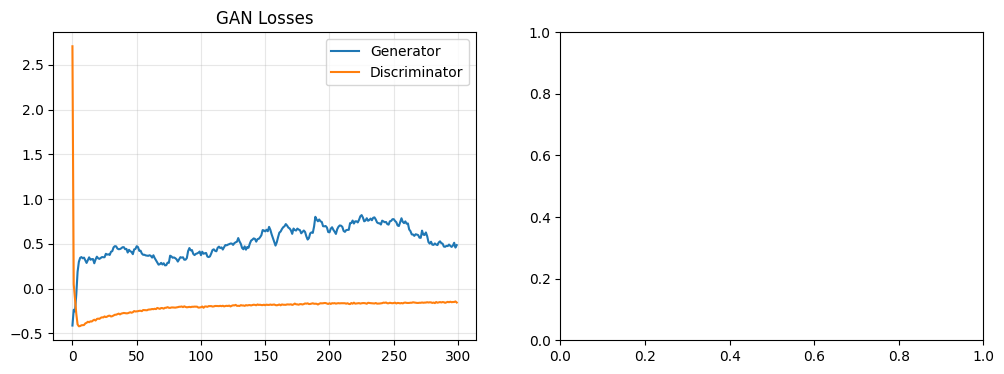

In [ ]:
# Run GAN with seed 42
seed = 42
print(f"\n{'='*60}")
print(f"GAN - Seed {seed}")
print(f"{'='*60}")

# Prepare data
X_train, X_test, y_train, y_test, prep = prepare_data(df, seed=seed)
prep.print_info()

# Train GAN
G_gan, D_gan, history_gan = train_gan(
    X_train, y_train, prep,
    latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    lr_g=LR_G, lr_d=LR_D, n_critic=N_CRITIC,
    lambda_gp=LAMBDA_GP, lambda_prop=LAMBDA_PROP,
    lambda_quant=LAMBDA_QUANT, lambda_moment=LAMBDA_MOMENT,
    lambda_corr=LAMBDA_CORR, lambda_cat=LAMBDA_CAT,
    conditional=False, seed=seed
)



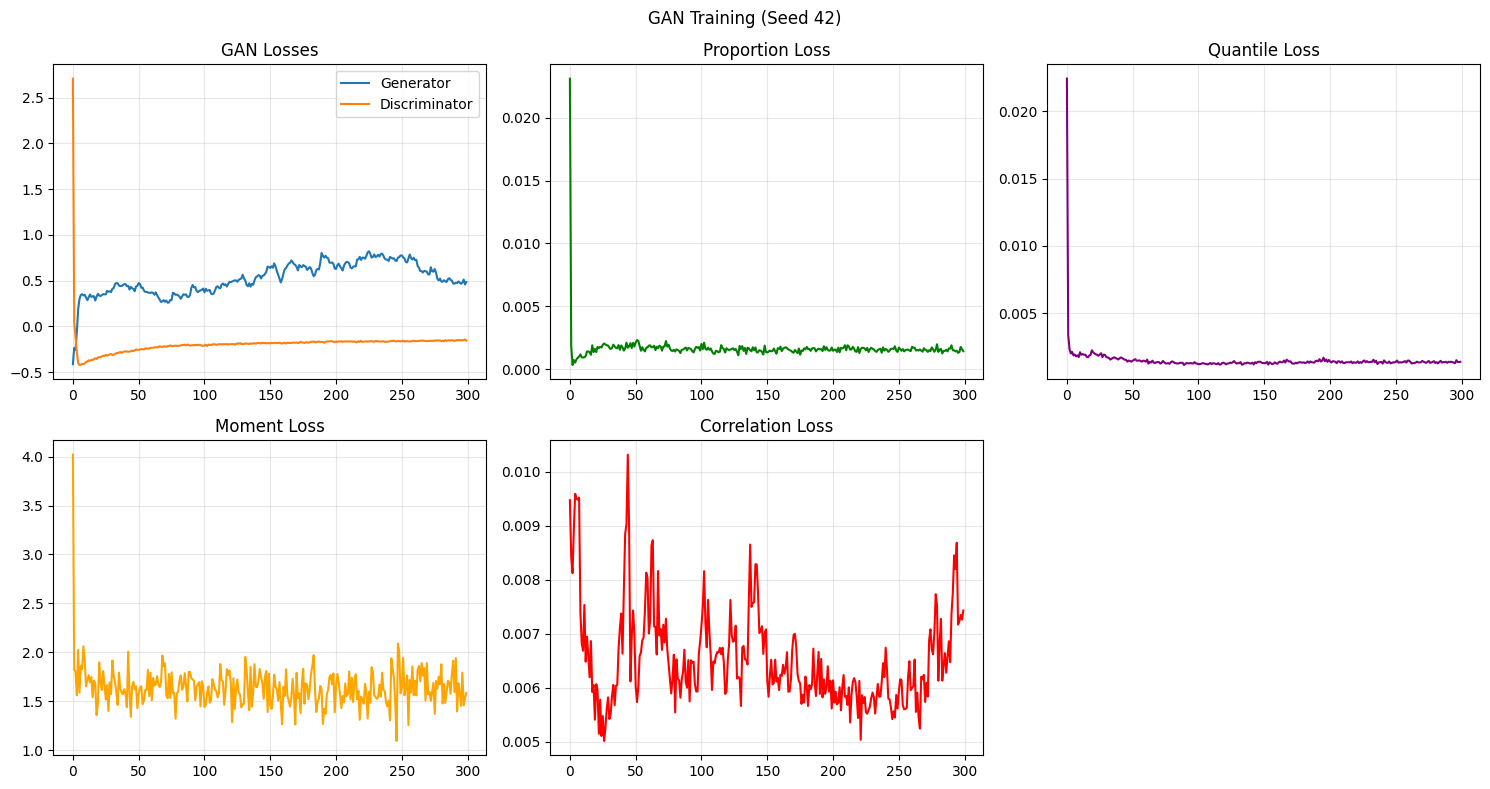

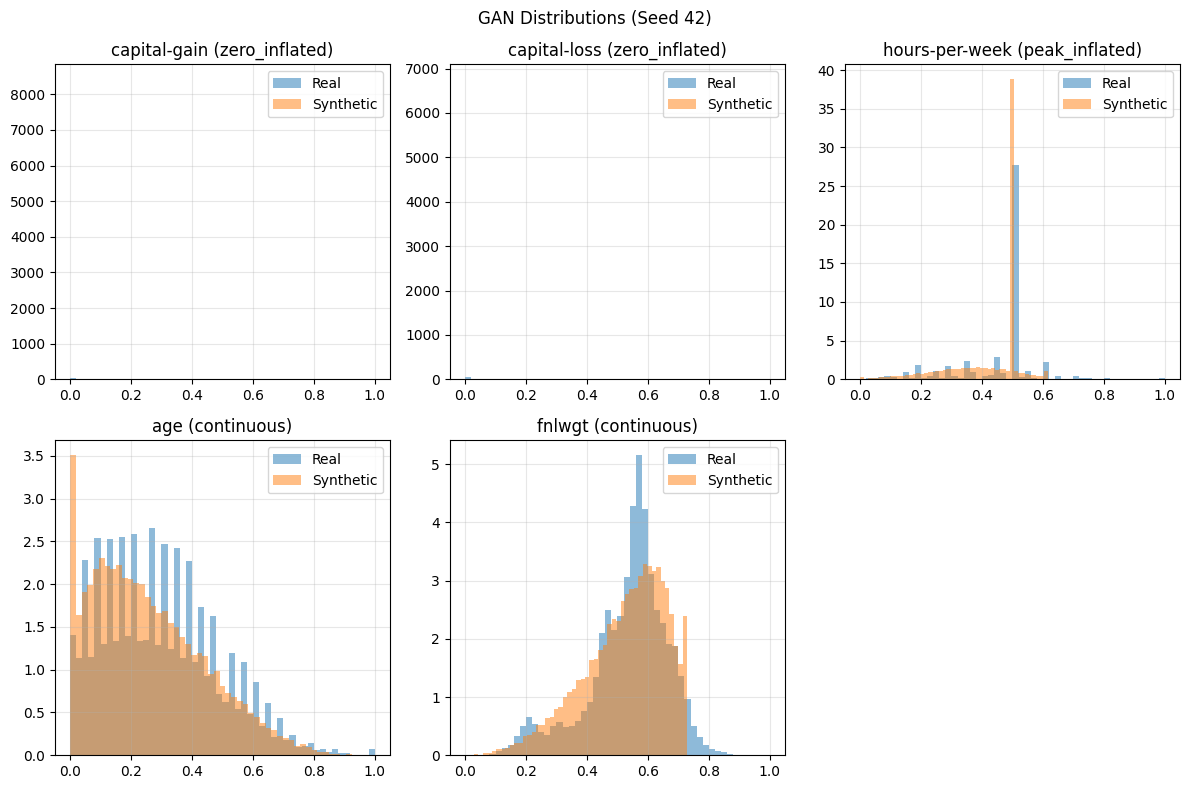


GAN Results (Seed 42):
  Detection AUC: 0.8974 (+/- 0.0029)
  Efficacy: 0.6089 (Real AUC: 0.9062, Synth AUC: 0.5518)


In [15]:
# Plot losses
plot_losses(history_gan, f"GAN Training (Seed {seed})", 
            f"{OUTPUT_DIR}/gan_losses_seed{seed}.png")

# Generate synthetic data
X_fake_gan = generate(G_gan, len(X_train), prep)
y_fake_gan = y_train.copy()

# Plot distributions
plot_distributions(X_train, X_fake_gan, prep, f"GAN Distributions (Seed {seed})",
                   f"{OUTPUT_DIR}/gan_dist_seed{seed}.png")

# Evaluate
det_auc_gan, det_std_gan = detection_metric(X_train, X_fake_gan, seed=seed)
eff_gan, auc_real_gan, auc_fake_gan = efficacy_metric(X_train, y_train, X_fake_gan, y_fake_gan, X_test, y_test, seed=seed)

print(f"\nGAN Results (Seed {seed}):")
print(f"  Detection AUC: {det_auc_gan:.4f} (+/- {det_std_gan:.4f})")
print(f"  Efficacy: {eff_gan:.4f} (Real AUC: {auc_real_gan:.4f}, Synth AUC: {auc_fake_gan:.4f})")


cGAN - Seed 42
Label ratio: [0.75917537 0.24082463]


Training:  17%|█▋        | 50/300 [07:53<39:22,  9.45s/it]

Epoch 50: D=-0.1762, G=-0.0619, Q=0.0015


Training:  33%|███▎      | 100/300 [15:37<30:43,  9.22s/it]

Epoch 100: D=-0.1190, G=-0.2122, Q=0.0013


Training:  50%|█████     | 150/300 [23:30<23:28,  9.39s/it]

Epoch 150: D=-0.0945, G=-0.0362, Q=0.0012


Training:  67%|██████▋   | 200/300 [31:16<15:21,  9.22s/it]

Epoch 200: D=-0.0680, G=-0.2170, Q=0.0012


Training:  83%|████████▎ | 250/300 [38:57<07:40,  9.21s/it]

Epoch 250: D=-0.0578, G=-0.2979, Q=0.0013


Training: 100%|██████████| 300/300 [46:38<00:00,  9.33s/it]

Epoch 300: D=-0.0554, G=-0.7168, Q=0.0013


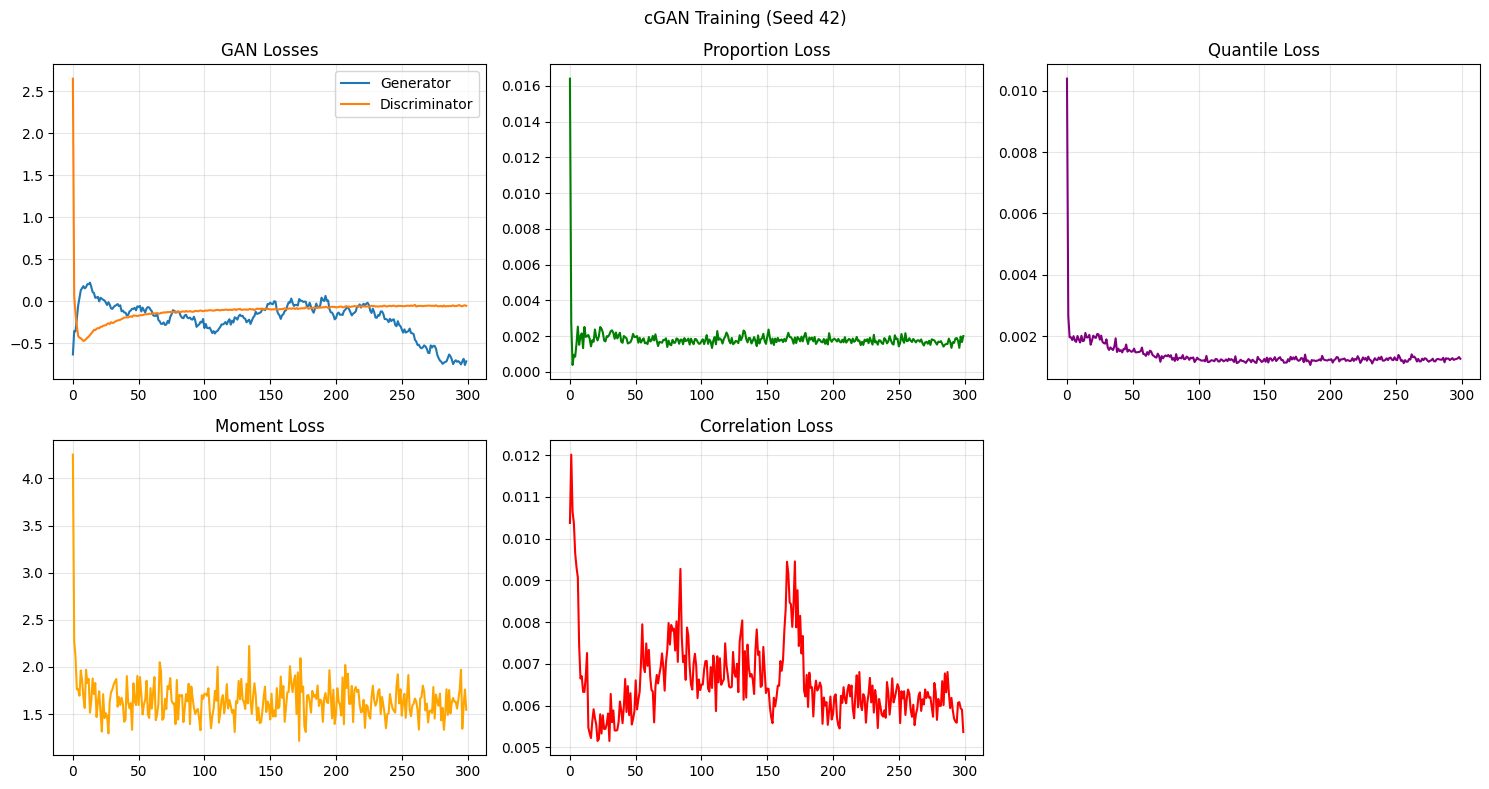

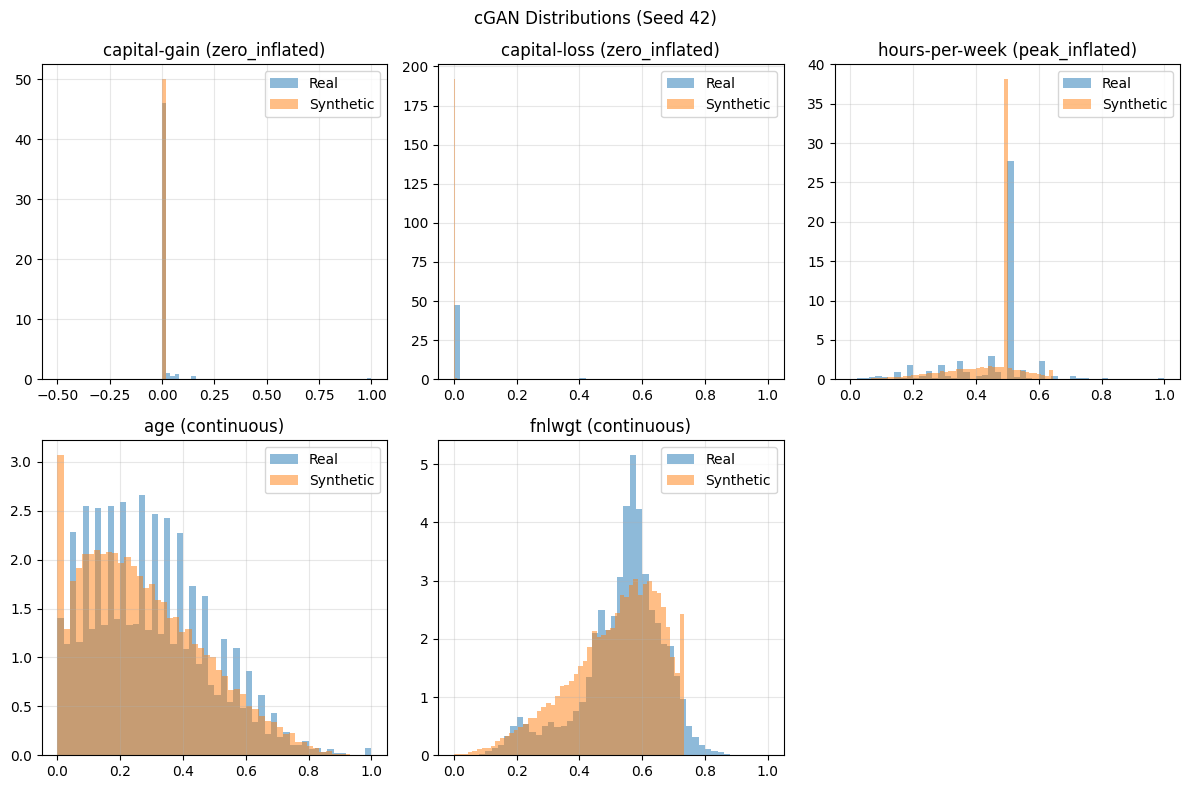


cGAN Results (Seed 42):
  Detection AUC: 0.8694 (+/- 0.0028)
  Efficacy: 0.9540 (Real AUC: 0.9062, Synth AUC: 0.8645)


In [16]:
# Run cGAN with seed 42
seed = 42
print(f"\n{'='*60}")
print(f"cGAN - Seed {seed}")
print(f"{'='*60}")

# Get label ratio from training data
label_counts = np.bincount(y_train)
label_ratio = label_counts / len(y_train)
print(f"Label ratio: {label_ratio}")

# Train cGAN
G_cgan, D_cgan, history_cgan = train_gan(
    X_train, y_train, prep,
    latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    lr_g=LR_G, lr_d=LR_D, n_critic=N_CRITIC,
    lambda_gp=LAMBDA_GP, lambda_prop=LAMBDA_PROP,
    lambda_quant=LAMBDA_QUANT, lambda_moment=LAMBDA_MOMENT,
    lambda_corr=LAMBDA_CORR, lambda_cat=LAMBDA_CAT,
    conditional=True, seed=seed
)

# Plot losses
plot_losses(history_cgan, f"cGAN Training (Seed {seed})",
            f"{OUTPUT_DIR}/cgan_losses_seed{seed}.png")

# Generate synthetic data with same label ratio
X_fake_cgan, y_fake_cgan = generate_with_label_ratio(G_cgan, len(X_train), prep, label_ratio)

# Plot distributions
plot_distributions(X_train, X_fake_cgan, prep, f"cGAN Distributions (Seed {seed})",
                   f"{OUTPUT_DIR}/cgan_dist_seed{seed}.png")

# Evaluate
det_auc_cgan, det_std_cgan = detection_metric(X_train, X_fake_cgan, seed=seed)
eff_cgan, auc_real_cgan, auc_fake_cgan = efficacy_metric(X_train, y_train, X_fake_cgan, y_fake_cgan, X_test, y_test, seed=seed)

print(f"\ncGAN Results (Seed {seed}):")
print(f"  Detection AUC: {det_auc_cgan:.4f} (+/- {det_std_cgan:.4f})")
print(f"  Efficacy: {eff_cgan:.4f} (Real AUC: {auc_real_cgan:.4f}, Synth AUC: {auc_fake_cgan:.4f})")

## Initial Comparison (Seed 42)

In [17]:
print("\n" + "="*60)
print("INITIAL COMPARISON (Seed 42)")
print("="*60)

print("\n| Model | Detection AUC | Efficacy |")
print("|-------|---------------|----------|")
print(f"| GAN   | {det_auc_gan:.4f} | {eff_gan:.4f} |")
print(f"| cGAN  | {det_auc_cgan:.4f} | {eff_cgan:.4f} |")

print("\nNote: Lower Detection AUC is better (synthetic similar to real)")
print("Note: Higher Efficacy is better (synthetic useful for training)")

# Store results
gan_results = [{'seed': 42, 'detection_auc': det_auc_gan, 'efficacy': eff_gan, 
                'auc_real': auc_real_gan, 'auc_synth': auc_fake_gan}]
cgan_results = [{'seed': 42, 'detection_auc': det_auc_cgan, 'efficacy': eff_cgan,
                 'auc_real': auc_real_cgan, 'auc_synth': auc_fake_cgan}]


INITIAL COMPARISON (Seed 42)

| Model | Detection AUC | Efficacy |
|-------|---------------|----------|
| GAN   | 0.8974 | 0.6089 |
| cGAN  | 0.8694 | 0.9540 |

Note: Lower Detection AUC is better (synthetic similar to real)
Note: Higher Efficacy is better (synthetic useful for training)


# Part 2: Remaining Seeds (123, 456)

In [18]:
# Run remaining GAN seeds
for seed in [123, 456]:
    print(f"\n{'='*60}")
    print(f"GAN - Seed {seed}")
    print(f"{'='*60}")
    
    # Prepare data
    X_train, X_test, y_train, y_test, prep = prepare_data(df, seed=seed)
    
    # Train GAN
    G, D, history = train_gan(
        X_train, y_train, prep,
        latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
        batch_size=BATCH_SIZE, epochs=EPOCHS,
        lr_g=LR_G, lr_d=LR_D, n_critic=N_CRITIC,
        lambda_gp=LAMBDA_GP, lambda_prop=LAMBDA_PROP,
        lambda_quant=LAMBDA_QUANT, lambda_moment=LAMBDA_MOMENT,
        lambda_corr=LAMBDA_CORR, lambda_cat=LAMBDA_CAT,
        conditional=False, seed=seed
    )
    
    # Generate and evaluate
    X_fake = generate(G, len(X_train), prep)
    y_fake = y_train.copy()
    
    det_auc, det_std = detection_metric(X_train, X_fake, seed=seed)
    eff, auc_real, auc_fake = efficacy_metric(X_train, y_train, X_fake, y_fake, X_test, y_test, seed=seed)
    
    print(f"\nResults: Detection AUC: {det_auc:.4f}, Efficacy: {eff:.4f}")
    
    gan_results.append({
        'seed': seed, 'detection_auc': det_auc, 'efficacy': eff,
        'auc_real': auc_real, 'auc_synth': auc_fake
    })


GAN - Seed 123
Train: (26048, 122), Test: (6513, 122)
Label distribution - Train: [0.75917537 0.24082463]


Training:  17%|█▋        | 50/300 [08:07<38:53,  9.33s/it]  

Epoch 50: D=-0.1995, G=0.1112, Q=0.0015


Training:  33%|███▎      | 100/300 [15:51<30:51,  9.26s/it]

Epoch 100: D=-0.1141, G=0.1306, Q=0.0013


Training:  50%|█████     | 150/300 [23:30<22:47,  9.11s/it]

Epoch 150: D=-0.0930, G=0.1273, Q=0.0013


Training:  67%|██████▋   | 200/300 [30:57<14:27,  8.68s/it]

Epoch 200: D=-0.0714, G=0.0228, Q=0.0011


Training:  83%|████████▎ | 250/300 [38:11<07:13,  8.66s/it]

Epoch 250: D=-0.0671, G=0.3045, Q=0.0012


Training: 100%|██████████| 300/300 [45:38<00:00,  9.13s/it]

Epoch 300: D=-0.0626, G=0.4397, Q=0.0012



Results: Detection AUC: 0.8786, Efficacy: 0.5688

GAN - Seed 456
Train: (26048, 123), Test: (6513, 123)
Label distribution - Train: [0.75917537 0.24082463]


Training:  17%|█▋        | 50/300 [07:36<37:58,  9.12s/it]

Epoch 50: D=-0.2467, G=1.2429, Q=0.0015


Training:  33%|███▎      | 100/300 [15:13<30:25,  9.13s/it]

Epoch 100: D=-0.1864, G=1.2804, Q=0.0012


Training:  50%|█████     | 150/300 [22:50<22:55,  9.17s/it]

Epoch 150: D=-0.0968, G=0.9252, Q=0.0012


Training:  67%|██████▋   | 200/300 [30:28<15:03,  9.03s/it]

Epoch 200: D=-0.0867, G=1.2484, Q=0.0013


Training:  83%|████████▎ | 250/300 [38:04<07:35,  9.10s/it]

Epoch 250: D=-0.0864, G=1.3655, Q=0.0014


Training: 100%|██████████| 300/300 [45:40<00:00,  9.13s/it]

Epoch 300: D=-0.0733, G=1.6052, Q=0.0013



Results: Detection AUC: 0.8774, Efficacy: 0.5286


In [19]:
# Run remaining cGAN seeds
for seed in [123, 456]:
    print(f"\n{'='*60}")
    print(f"cGAN - Seed {seed}")
    print(f"{'='*60}")
    
    # Prepare data
    X_train, X_test, y_train, y_test, prep = prepare_data(df, seed=seed)
    
    # Get label ratio
    label_counts = np.bincount(y_train)
    label_ratio = label_counts / len(y_train)
    
    # Train cGAN
    G, D, history = train_gan(
        X_train, y_train, prep,
        latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
        batch_size=BATCH_SIZE, epochs=EPOCHS,
        lr_g=LR_G, lr_d=LR_D, n_critic=N_CRITIC,
        lambda_gp=LAMBDA_GP, lambda_prop=LAMBDA_PROP,
        lambda_quant=LAMBDA_QUANT, lambda_moment=LAMBDA_MOMENT,
        lambda_corr=LAMBDA_CORR, lambda_cat=LAMBDA_CAT,
        conditional=True, seed=seed
    )
    
    # Generate and evaluate
    X_fake, y_fake = generate_with_label_ratio(G, len(X_train), prep, label_ratio)
    
    det_auc, det_std = detection_metric(X_train, X_fake, seed=seed)
    eff, auc_real, auc_fake = efficacy_metric(X_train, y_train, X_fake, y_fake, X_test, y_test, seed=seed)
    
    print(f"\nResults: Detection AUC: {det_auc:.4f}, Efficacy: {eff:.4f}")
    
    cgan_results.append({
        'seed': seed, 'detection_auc': det_auc, 'efficacy': eff,
        'auc_real': auc_real, 'auc_synth': auc_fake
    })


cGAN - Seed 123
Train: (26048, 122), Test: (6513, 122)
Label distribution - Train: [0.75917537 0.24082463]


Training:  17%|█▋        | 50/300 [07:41<38:23,  9.21s/it]

Epoch 50: D=-0.1624, G=-0.3692, Q=0.0013


Training:  33%|███▎      | 100/300 [15:22<30:41,  9.21s/it]

Epoch 100: D=-0.1057, G=-0.0539, Q=0.0011


Training:  50%|█████     | 150/300 [23:03<23:00,  9.20s/it]

Epoch 150: D=-0.0846, G=-0.2115, Q=0.0012


Training:  67%|██████▋   | 200/300 [30:45<15:39,  9.39s/it]

Epoch 200: D=-0.0716, G=-0.2342, Q=0.0012


Training:  83%|████████▎ | 250/300 [38:30<07:39,  9.20s/it]

Epoch 250: D=-0.0617, G=-0.0569, Q=0.0013


Training: 100%|██████████| 300/300 [46:12<00:00,  9.24s/it]

Epoch 300: D=-0.0559, G=-0.1363, Q=0.0013



Results: Detection AUC: 0.8656, Efficacy: 0.9493

cGAN - Seed 456
Train: (26048, 123), Test: (6513, 123)
Label distribution - Train: [0.75917537 0.24082463]


Training:  17%|█▋        | 50/300 [07:42<38:22,  9.21s/it]

Epoch 50: D=-0.1774, G=-0.6681, Q=0.0014


Training:  33%|███▎      | 100/300 [15:23<30:45,  9.23s/it]

Epoch 100: D=-0.1262, G=-1.0880, Q=0.0013


Training:  50%|█████     | 150/300 [23:17<23:51,  9.54s/it]

Epoch 150: D=-0.0940, G=-1.1527, Q=0.0012


Training:  67%|██████▋   | 200/300 [31:10<15:59,  9.60s/it]

Epoch 200: D=-0.0766, G=-1.1894, Q=0.0013


Training:  83%|████████▎ | 250/300 [39:00<07:54,  9.49s/it]

Epoch 250: D=-0.0599, G=-1.2884, Q=0.0013


Training: 100%|██████████| 300/300 [46:50<00:00,  9.37s/it]

Epoch 300: D=-0.0676, G=-1.1293, Q=0.0013



Results: Detection AUC: 0.8734, Efficacy: 0.9491



# Final Summary
---

In [20]:
print("\n" + "="*60)
print("FINAL RESULTS (Average over 3 seeds)")
print("="*60)

gan_df = pd.DataFrame(gan_results)
cgan_df = pd.DataFrame(cgan_results)

print("\n| Model | Detection AUC | Efficacy |")
print("|-------|---------------|----------|")
print(f"| GAN   | {gan_df['detection_auc'].mean():.4f} +/- {gan_df['detection_auc'].std():.4f} | {gan_df['efficacy'].mean():.4f} +/- {gan_df['efficacy'].std():.4f} |")
print(f"| cGAN  | {cgan_df['detection_auc'].mean():.4f} +/- {cgan_df['detection_auc'].std():.4f} | {cgan_df['efficacy'].mean():.4f} +/- {cgan_df['efficacy'].std():.4f} |")

print("\n\nDetailed GAN Results:")
print(gan_df.to_string(index=False))

print("\n\nDetailed cGAN Results:")
print(cgan_df.to_string(index=False))

print("\n\nNote: Lower Detection AUC is better (synthetic similar to real)")
print("Note: Higher Efficacy is better (synthetic useful for training)")


FINAL RESULTS (Average over 3 seeds)

| Model | Detection AUC | Efficacy |
|-------|---------------|----------|
| GAN   | 0.8845 +/- 0.0112 | 0.5688 +/- 0.0402 |
| cGAN  | 0.8694 +/- 0.0039 | 0.9508 +/- 0.0028 |


Detailed GAN Results:
 seed  detection_auc  efficacy  auc_real  auc_synth
   42       0.897388  0.608905  0.906197   0.551788
  123       0.878550  0.568797  0.899608   0.511695
  456       0.877421  0.528592  0.900077   0.475774


Detailed cGAN Results:
 seed  detection_auc  efficacy  auc_real  auc_synth
   42       0.869362  0.953974  0.906197   0.864488
  123       0.865588  0.949255  0.899608   0.853957
  456       0.873352  0.949053  0.900077   0.854221


Note: Lower Detection AUC is better (synthetic similar to real)
Note: Higher Efficacy is better (synthetic useful for training)
